In [1]:
import gc
import inspect
import json
import os
import pickle

import dill
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchaudio
from IPython import display
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

from dataset.dataset import AudioDataset
from utils import MelSpec

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [3]:
def clear_mem():
    gc.collect()
    torch.cuda.empty_cache()

In [4]:
SAMPLE_RATE = 22050
SEQ_LENGTH = 16000
N_FFT = 1024
WIN_LEN = 1024
HOP_LEN = 256
PAD = (N_FFT - HOP_LEN) // 2
MEL_SPEC_CONF = dict(
    sample_rate=SAMPLE_RATE,
    n_fft=N_FFT,
    win_length=WIN_LEN,
    hop_length=HOP_LEN,
    n_mels=80,
    f_min=0,
    f_max=8000,
    power=1,
    center=False,
    pad=PAD,
    mel_scale="slaney",
    norm="slaney",
)

In [5]:
MEL_SPEC_CONF

{'sample_rate': 22050,
 'n_fft': 1024,
 'win_length': 1024,
 'hop_length': 256,
 'n_mels': 80,
 'f_min': 0,
 'f_max': 8000,
 'power': 1,
 'center': False,
 'pad': 384,
 'mel_scale': 'slaney',
 'norm': 'slaney'}

In [6]:
MODEL_TAG = "waveglow_22k_100"

In [7]:
try:
    os.mkdir(f"models/{MODEL_TAG}")
    os.mkdir(f"models/{MODEL_TAG}/checkpoints")
    os.mkdir(f"models/{MODEL_TAG}/samples")
    print("ok")
except FileExistsError:
    print("already exists")

already exists


In [8]:
def lambda2str(fn):
    if fn is None:
        return "None"
    return inspect.getsourcelines(fn)[0][0].strip()

In [9]:
try:
    MEL_SPEC_CONF = dill.load(open(f"models/{MODEL_TAG}/mel_spec_conf", "rb"))
except:
    dill.dump(MEL_SPEC_CONF, open(f"models/{MODEL_TAG}/mel_spec_conf", "wb"))

In [10]:
dill.dump(MEL_SPEC_CONF, open(f"models/{MODEL_TAG}/mel_spec_conf", "wb"))

In [11]:
dataset = AudioDataset(
    "dataset/russian-open-stt/audio_dataset/audio_files",
    SAMPLE_RATE,
    segment_length=SEQ_LENGTH,
)
dataset_val = AudioDataset("dataset/russian-open-stt/audio_dataset/audio_files", SAMPLE_RATE)
mel_featurizer = MelSpec(MEL_SPEC_CONF)

train_ratio = 0.9
train_size = int(len(dataset) * train_ratio)

try:
    random_indexes = pickle.load(open(f"models/{MODEL_TAG}/indexes", "rb"))
except:
    random_indexes = torch.randperm(len(dataset)).tolist()
    pickle.dump(random_indexes, open(f"models/{MODEL_TAG}/indexes", "wb"))
dataset_train = Subset(dataset, random_indexes[:train_size])
dataset_test = Subset(dataset_val, random_indexes[train_size:])

In [12]:
len(dataset_train), len(dataset_test)

(106200, 11800)

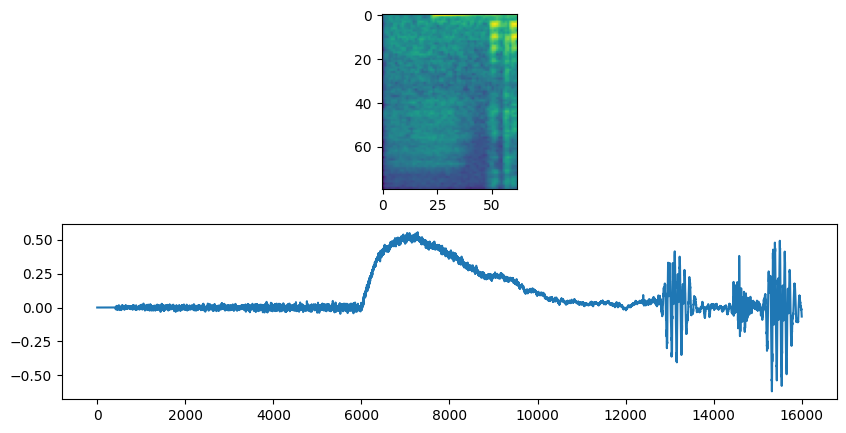

In [13]:
audio = dataset_train[0]
mel = mel_featurizer(audio)
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
axes[0].imshow(mel)
axes[1].plot(audio[0])

display.Audio(audio, rate=dataset.sample_rate)

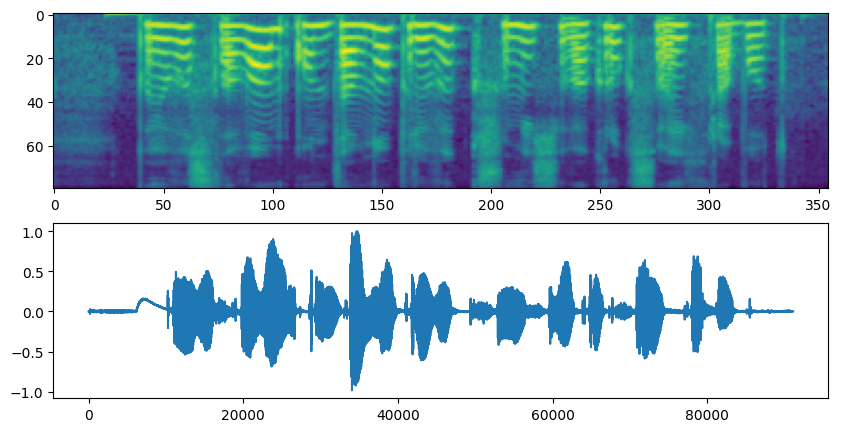

In [14]:
audio = dataset_test[0]
mel = mel_featurizer(audio)
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
axes[0].imshow(mel)
axes[1].plot(audio[0])

display.Audio(audio, rate=dataset.sample_rate)

In [15]:
def collate_fn(items):
    audio_len = [audio.size(1) for audio, _ in items]
    texts = [code_text(text) for _, text in items]
    text_len = [text.size(1) for text in texts]

    audio_batch = torch.zeros((len(items), max(audio_len)))
    text_batch = torch.zeros((len(texts), max(text_len)))
    for i, (audio, _) in enumerate(items):
        audio_batch[i, : audio_len[i]] = audio
        text_batch[i, : text_len[i]] = texts[i]
    return audio_batch, text_batch.long()

In [16]:
dataloader_train = DataLoader(dataset_train, 4, drop_last=True, num_workers=24, pin_memory=True)
dataloader_test = DataLoader(dataset_test, 1, pin_memory=True)

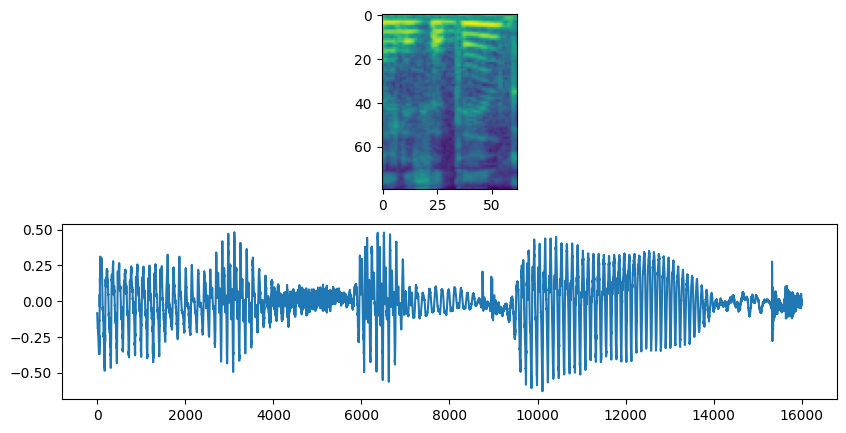

In [17]:
audios = next(iter(dataloader_train))
mels = mel_featurizer(audios)
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
axes[0].imshow(mels[0])
axes[1].plot(audios[0][0])

display.Audio(audios[0], rate=dataset.sample_rate)

In [18]:
from waveglow.waveglow import WaveGlow

In [19]:
model = WaveGlow(80, 12, 8, 8, 256).to(DEVICE)

In [20]:
opt = optim.Adam(model.parameters(), lr=1e-4)

In [21]:
mel_featurizer = MelSpec(MEL_SPEC_CONF).to(DEVICE)
mel_featurizer.conf

{'sample_rate': 22050,
 'n_fft': 1024,
 'win_length': 1024,
 'hop_length': 256,
 'n_mels': 80,
 'f_min': 0,
 'f_max': 8000,
 'power': 1,
 'center': False,
 'pad': 384,
 'mel_scale': 'slaney',
 'norm': 'slaney'}

In [22]:
# @torch.jit.script
# def criterion(z, log_s, log_det, sigma=torch.tensor(1.0)):
#     loss = torch.sum(z * z) / (2 * sigma * sigma) - log_s - log_det
#     return loss / (z.size(0) * z.size(1) * z.size(2))

In [23]:
class WaveGlowLoss(torch.nn.Module):
    def __init__(self, sigma=1.0):
        super().__init__()
        self.sigma = sigma

    def forward(self, z, log_s, log_det):
        loss = torch.sum(z * z) / (2 * self.sigma * self.sigma) - log_s - log_det
        return loss / (z.size(0) * z.size(1) * z.size(2))

In [24]:
criterion = WaveGlowLoss(sigma=1.0)

In [25]:
# wav = next(iter(dataloader_train))
# wav = wav.to(DEVICE)
# mels = mel_featurizer(wav)

# z, log_s_list, log_det_list = model(wav.squeeze(1), mels)

# print(wav.size())
# print(mels.size())
# print(z.size())
# print(criterion(z, log_s_list, log_det_list).backward())

# del wav
# del mels
# del z
# del log_s_list
# del log_det_list
# clear_mem()

In [26]:
# assert False

In [ ]:
writer = SummaryWriter()

In [27]:
def save_checkpoint(model, opt, epoch, iteration, loss_history):
    checkpoint = epoch % 10
    torch.save(model.state_dict(), f"models/{MODEL_TAG}/checkpoints/model_{checkpoint}.pt")
    torch.save(opt.state_dict(), f"models/{MODEL_TAG}/checkpoints/opt_{checkpoint}.pt")
    json.dump(loss_history, open(f"models/{MODEL_TAG}/losses.json", "w"))
    if iteration == -1:
        epoch += 1
        iteration = 0
    json.dump({"epoch": epoch, "iteration": iteration}, open(f"models/{MODEL_TAG}/progress.json", "w"))

In [28]:
def train(epoch, model, opt, dataloader, iter_offset=0):
    progress = tqdm(dataloader, initial=iter_offset, total=len(dataloader) + iter_offset, desc=f"Train #{epoch}\n")

    losses = []
    if iter_offset != 0:
        losses = train_losses.pop(-1)

    model.train()
    for wav in progress:
        wav = wav.to(DEVICE)
        # wav = preemphasis(wav)
        mel = mel_featurizer(wav).detach()

        z, log_s, log_det = model(wav.squeeze(1), mel)
        loss = criterion(z, log_s, log_det)

        model.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

        progress.set_description(
            (f"Train #{epoch} | " f"loss: {loss.item():0.3} | " f"epoch mean: {np.mean(losses):0.3} | ")
        )

        if (progress.n + 1) % 2000 == 0:
            save_checkpoint(model, opt, epoch, progress.n + 1, train_losses + [losses])

    return losses

In [29]:
def test(epoch, model, dataloader, n_samples=10):
    progress = tqdm(range(10), desc=f"Test #{epoch}\n")
    dataloader = iter(dataloader)

    model.eval()
    with torch.no_grad():
        for i in progress:
            wav = next(dataloader)
            wav = wav.to(DEVICE)
            # wav = preemphasis(wav)

            mel = mel_featurizer(wav).detach()
            wav_fake = model.infer(mel.unsqueeze(0))

            # wav_fake = deemphasis(wav_fake)
            torchaudio.save(
                f"models/{MODEL_TAG}/samples/{epoch}_{i}_o.wav",
                wav.squeeze(1).cpu(),
                SAMPLE_RATE,
            )
            torchaudio.save(
                f"models/{MODEL_TAG}/samples/{epoch}_{i}_f.wav",
                wav_fake.cpu(),
                SAMPLE_RATE,
            )

In [30]:
def plot(train_losses):
    plt.figure(figsize=(8, 6))

    plt.plot(
        list(
            map(
                lambda loss: min(loss, 0),
                sum([losses for losses in train_losses[:]], start=[]),
            )
        ),
        label="loss",
        color="#7744bb",
    )
    epoch_mean = [np.mean(losses) for losses in train_losses]
    plt.plot(np.cumsum([len(losses) for losses in train_losses]), epoch_mean, "-o", label="epoch mean", color="#55ee11")

    plt.grid()
    plt.tight_layout()
    plt.legend()

    plt.show()

In [31]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
EPOCHS = 132

try:
    progress = json.load(open(f"models/{MODEL_TAG}/progress.json", "r"))
    EPOCH_OFFSET = progress["epoch"]
    ITER_OFFSET = progress["iteration"]
except:
    EPOCH_OFFSET = 0
    ITER_OFFSET = 0

checkpoint = (EPOCH_OFFSET - 1) % 10
train_losses = []

if EPOCH_OFFSET:
    train_losses = json.load(open(f"models/{MODEL_TAG}/losses.json", "r"))
    model.load_state_dict(torch.load(f"models/{MODEL_TAG}/checkpoints/model_{checkpoint}.pt", map_location="cuda"))
    opt.load_state_dict(torch.load(f"models/{MODEL_TAG}/checkpoints/opt_{checkpoint}.pt", map_location="cuda"))

In [32]:
len(train_losses)

130

In [33]:
dataset_train = Subset(dataset, random_indexes[ITER_OFFSET * 4 : train_size])
dataloader_train = DataLoader(dataset_train, 4, drop_last=True, num_workers=24, pin_memory=True)

In [34]:
len(dataloader_train)

26550

Train #130
:   0%|          | 0/26550 [00:00<?, ?it/s]

Test #130
:   0%|          | 0/10 [00:00<?, ?it/s]

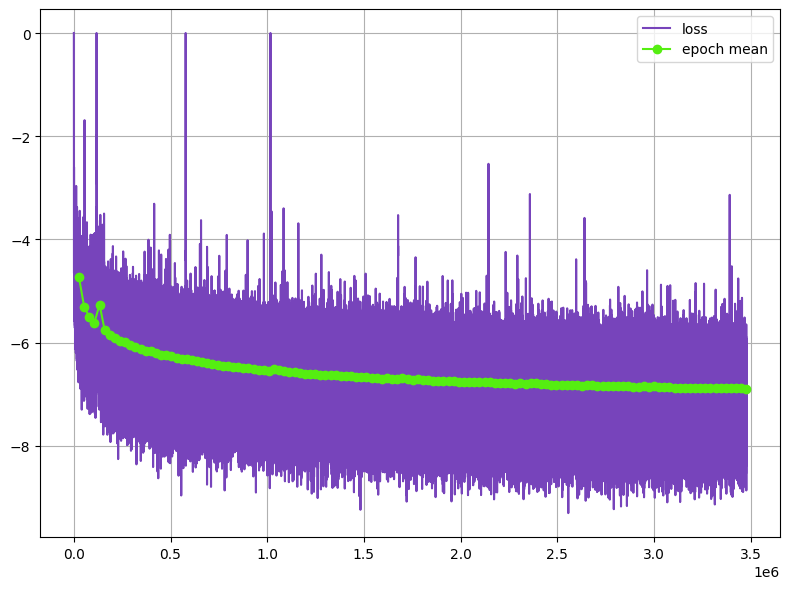

Train #131
:   0%|          | 0/26550 [00:00<?, ?it/s]

Test #131
:   0%|          | 0/10 [00:00<?, ?it/s]

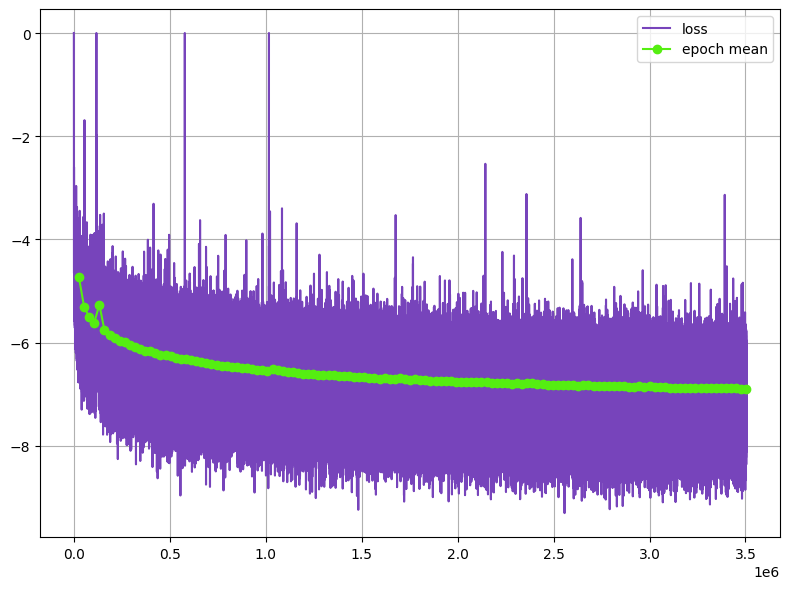

In [35]:
for epoch in range(EPOCH_OFFSET, EPOCHS):
    train_losses.append(train(epoch, model, opt, dataloader_train, ITER_OFFSET))
    test(epoch, model, dataloader_test)

    if ITER_OFFSET != 0:
        ITER_OFFSET = 0
        dataset_train = Subset(dataset, random_indexes[:train_size])
        dataloader_train = DataLoader(dataset_train, 4, drop_last=True, num_workers=24, pin_memory=True)

    save_checkpoint(model, opt, epoch, -1, train_losses)
    # display.clear_output(True)
    plot(train_losses)

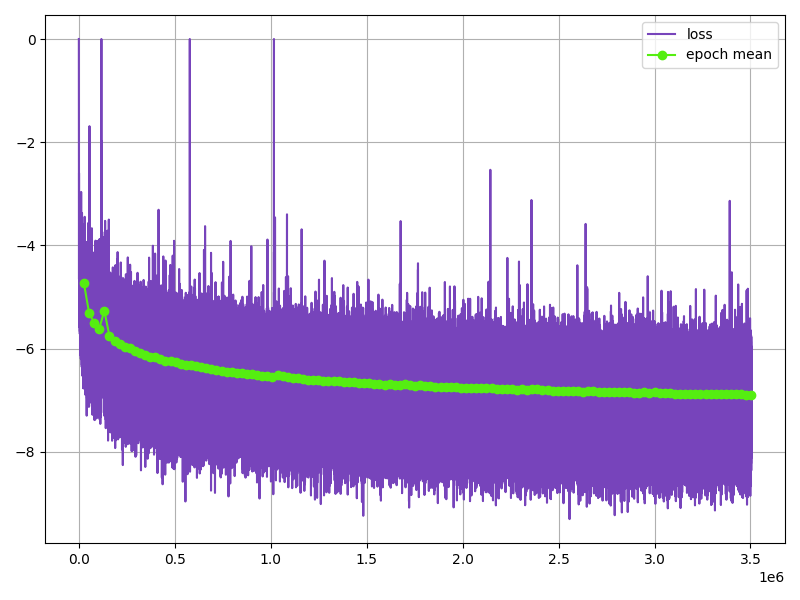

In [36]:
%matplotlib widget

plot(train_losses)